## Модели ARIMA и GARCH

In [2]:
import pandas as pd
import numpy as np
import tqdm
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
from scipy.stats import boxcox
from math import sqrt

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sn

In [5]:
# проверка стационарности Дики-Фуллера
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [6]:
# Time-series plot
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        # qqplot для определения нормальности распределения остатков
        sm.qqplot(y, line='s', ax=qq_ax)
        
        plt.tight_layout()
    return

## В чем идея

Будем представлять временной ряд $y_t$ в виде

$y_t = T + S + E$

где T - тренд, S - сезонная компонента, E - ошибка прогноза

Будем рассматривать разные "порождающие" модели для рядов. Интуитивно - если ряд хорошо описывается моделью, то остатки - независимые и одинаково распределенные

## Белый шум и случайные блуждания

Первая модель - которую мы рассмотрим - белый шум.

$y_t = E$

Results of Dickey-Fuller Test:
Test Statistic                 -32.118704
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    999.000000
Critical Value (1%)             -3.436913
Critical Value (5%)             -2.864437
Critical Value (10%)            -2.568313
dtype: float64


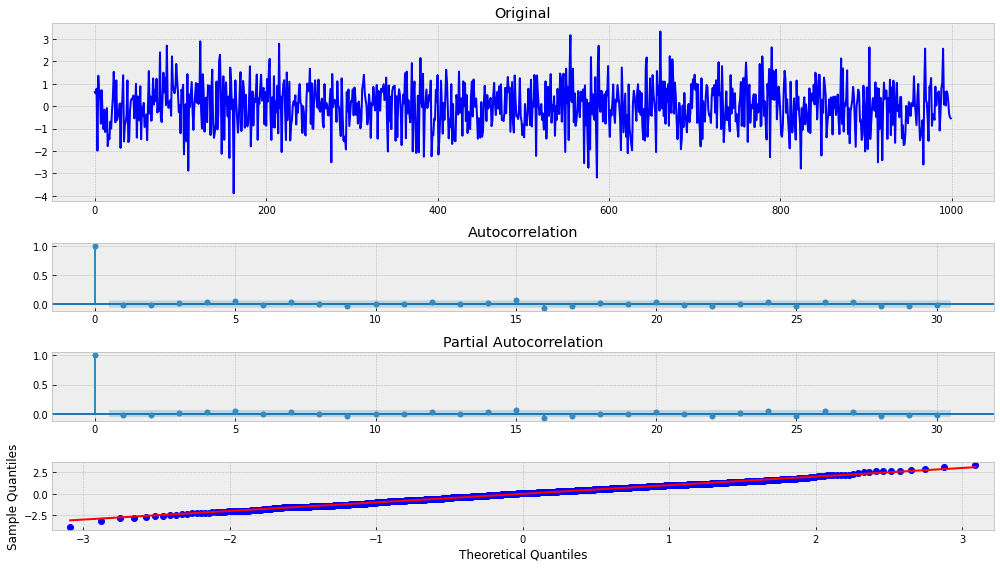

In [7]:
randser = np.random.normal(size=1000)
tsplot(randser, lags=30)

## Random Walk

### Следующая модель - это модель случайного блуждания.

$y_t = y_{t-1} + \epsilon_{t}$

где $\epsilon_{t}$ - белый шум.  
Особенность случайного блуждания в том, что он не стационарен, т.е. его свойства меняются со временем и предсказать его невозможно

## Практика - реализуйте процесс случайного блуждания

In [13]:
import random
eps = [random.randint(-5,5) for _ in range(0,1000)]
result = [randser[i-1]+eps[i] for i in range(1,100)]

Давайте проверим, подходит ли модель белого шума под сгенерированные данные. Для этого надо из текущего измерения вычесть предыдущие и посмотреть остатки

Results of Dickey-Fuller Test:
Test Statistic                -9.386690e+00
p-value                        6.729554e-16
#Lags Used                     3.000000e+00
Number of Observations Used    9.400000e+01
Critical Value (1%)           -3.501912e+00
Critical Value (5%)           -2.892815e+00
Critical Value (10%)          -2.583454e+00
dtype: float64


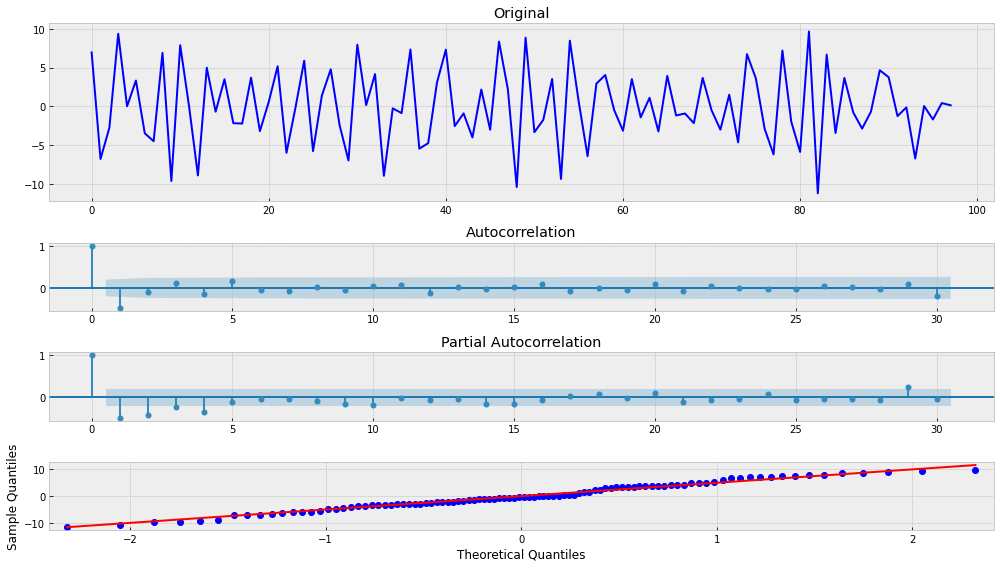

In [14]:
tsplot(np.diff(result), lags=30)

In [18]:
x = np.random.normal(100)
x = np.cumsum(x)
tsplot(np.diff(x))

Results of Dickey-Fuller Test:


ValueError: sample size is too short to use selected regression component

Однако для реальных данных такой модели конечно не достаточно.

# AR(p)

Авторегрессионная модель — модель временных рядов, в которой значения временного ряда в данный момент линейно зависят от предыдущих значений этого же ряда. Авторегрессионный процесс порядка p (AR(p)-процесс) определяется следующим образом

$y_t = c + \sum_{i=1}^P a_i y_{t-i} + \epsilon_t$

где $\epsilon_t$ - белый шум

Сделаем симуляцию процесса AR(1) и посмотрим, сумеет ли модель AR правильно подобрать коэффициенты

Results of Dickey-Fuller Test:
Test Statistic                -1.877613e+01
p-value                        2.024692e-30
#Lags Used                     0.000000e+00
Number of Observations Used    9.990000e+02
Critical Value (1%)           -3.436913e+00
Critical Value (5%)           -2.864437e+00
Critical Value (10%)          -2.568313e+00
dtype: float64


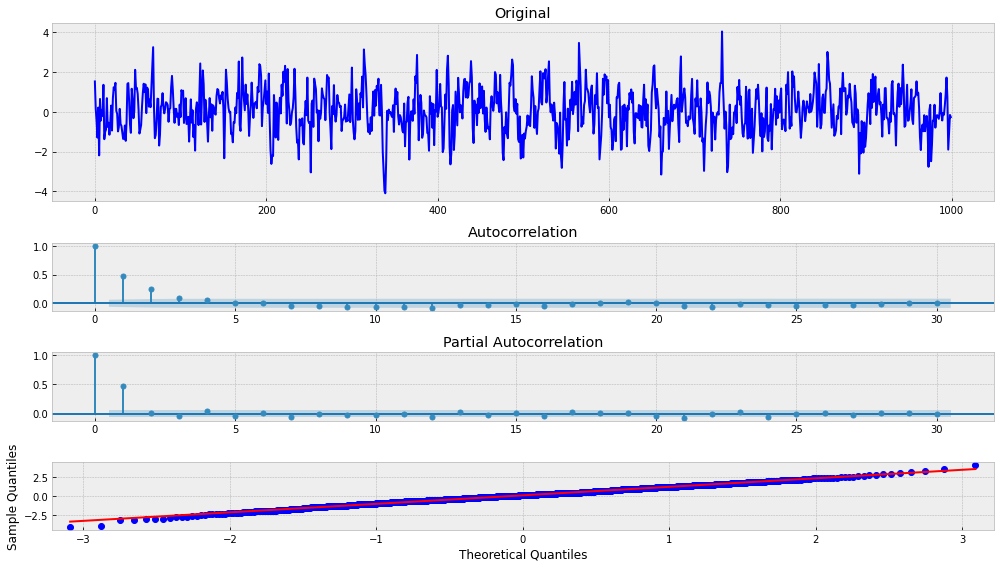

In [23]:
np.random.seed(1)
n_samples = int(1000)
a = 0.5
x = w = np.random.normal(size=n_samples)

for t in range(n_samples):
    x[t] = a*x[t-1] + w[t]
    
tsplot(x, lags=30)

https://www.statsmodels.org/stable/generated/statsmodels.tsa.ar_model.AR.fit.html#statsmodels.tsa.ar_model.AR.fit

In [ ]:
# реализация авторегрессии из statsmodels
mdl = smt.AR(x).fit(maxlag=30, ic='aic', trend='nc')
best_order = smt.AR(x).select_order(maxlag=30, ic='aic', trend='nc')

true_order = 1
print('\nalpha estimate: {:3.5f} | best lag order = {}'.format(mdl.params[0], best_order))
print('\ntrue alpha = {} | true order = {}'.format(a, true_order))

### Посмотрим остатки

Results of Dickey-Fuller Test:
Test Statistic                 -31.856304
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    998.000000
Critical Value (1%)             -3.436919
Critical Value (5%)             -2.864440
Critical Value (10%)            -2.568314
dtype: float64


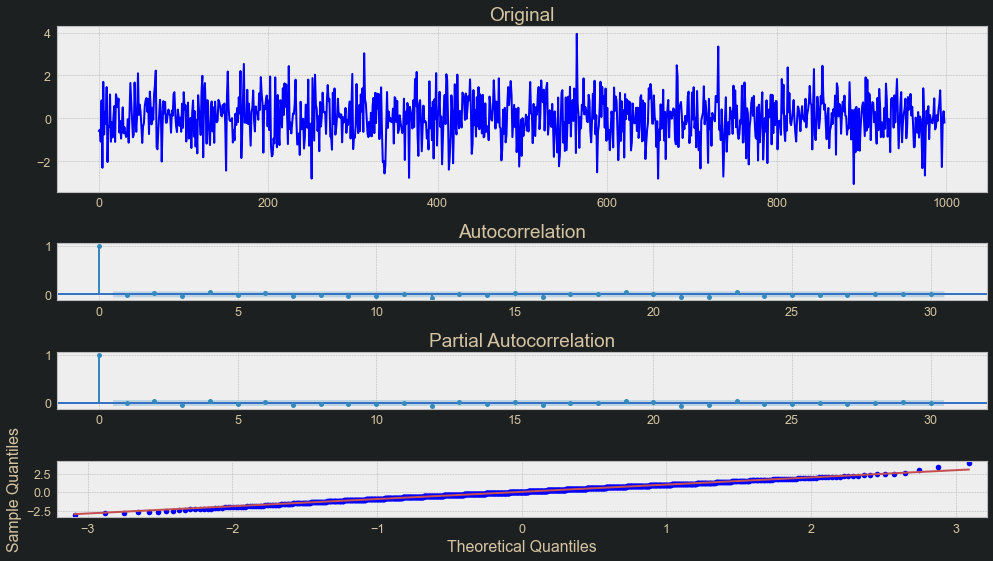

In [12]:
tsplot(mdl.resid, lags=30)

## Практика - сделайте симуляцию процесса AR(2) с параметрами 0.6 и 0.3 и посмотрите, сумеет ли модель AR правильно подобрать коэффициенты и посмотрите остатки

Results of Dickey-Fuller Test:
Test Statistic                -6.988709e+00
p-value                        7.845875e-10
#Lags Used                     1.000000e+00
Number of Observations Used    9.980000e+02
Critical Value (1%)           -3.436919e+00
Critical Value (5%)           -2.864440e+00
Critical Value (10%)          -2.568314e+00
dtype: float64


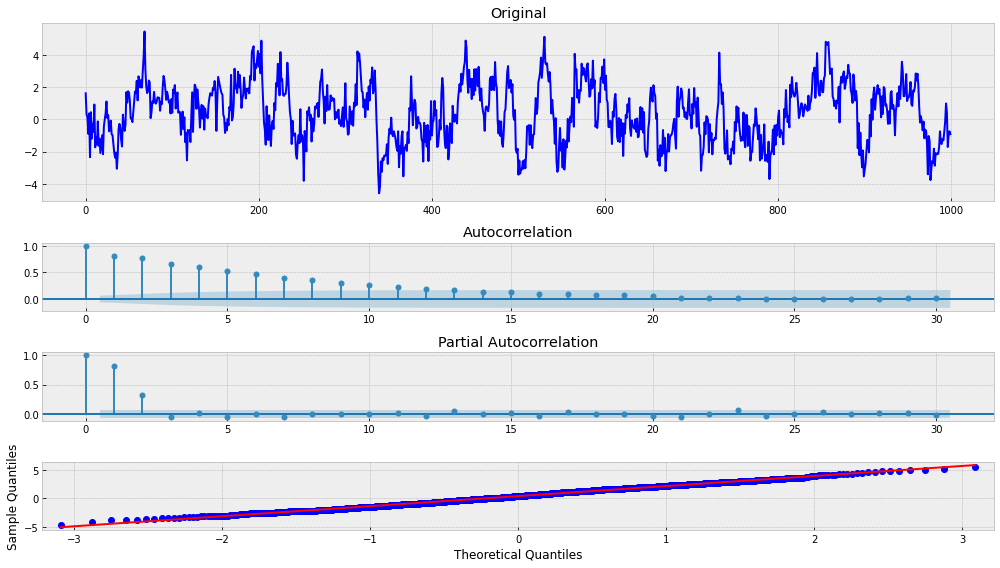

In [28]:
np.random.seed(1)
n_samples = int(1000)
x = w = np.random.normal(size=n_samples)

for t in range(n_samples):
    x[t] = 0.6*x[t-1]+0.3*x[t-2] + w[t]
    
tsplot(x, lags=30)

In [41]:
# реализация авторегрессии из statsmodels
mdl = smt.AR(x).fit(maxlag=30,  trend='nc')
best_order = smt.AR(x).select_order(maxlag=30, ic='aic', trend='nc')

# true_order = 1
# print('\nalpha estimate: {:3.5f} | best lag order = {}'.format(mdl.params, best_order))
# print('\ntrue alpha = {} | true order = {}'.format(a, true_order))

In [42]:
mdl.params

array([ 0.5889984 ,  0.31448158, -0.0335453 ,  0.04311727, -0.02049638,
        0.01443267, -0.03541785, -0.00561968, -0.00418893, -0.01004223,
        0.03462041, -0.06449197,  0.04862608, -0.00401265,  0.01905311,
       -0.05040854,  0.03467016,  0.01588642,  0.03304697, -0.00599115,
       -0.07375457, -0.02803392,  0.08585626, -0.03987362, -0.01555951,
        0.0265313 , -0.00872783,  0.00241703,  0.02721222, -0.00750855])

In [38]:
best_order

3

## Попробуем на реальных данных

In [47]:
series = pd.read_csv("C:/Users/Timvo/JupyterFolder/ITACADEMY/LESSON32(TIME_SERIES_ANALIZE)/Series/international-airline-passengers.csv")['Count']
series = boxcox(series, 0) # для приведения к стационарному

Results of Dickey-Fuller Test:
Test Statistic                  -1.717017
p-value                          0.422367
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


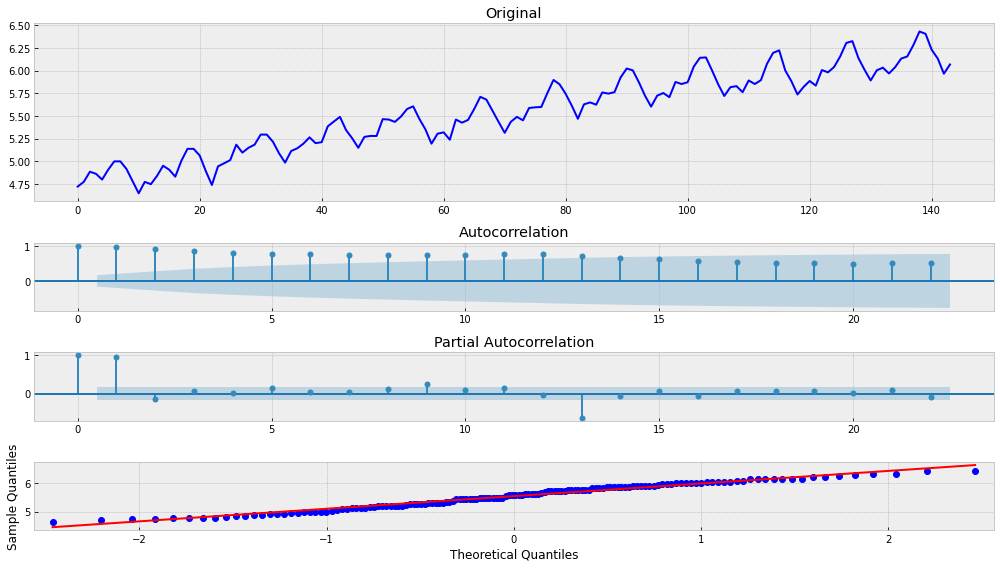

In [48]:
tsplot(series)

In [50]:
mdl = smt.AR(series).fit(maxlag=30, ic='aic', trend='nc')
print(mdl.params)

[ 0.57771154  0.22901853  0.06195854 -0.08919923  0.24920719 -0.15657936
  0.04266833 -0.01690364  0.24480034 -0.29458944  0.03968739  0.48535593
 -0.13295218 -0.31857377  0.17769943 -0.12830694 -0.00824594 -0.12456788
  0.17055048 -0.20087872  0.00313821  0.07960796  0.21843347  0.19825546
 -0.12661933 -0.17744898]


### Посмотрим на остатки

Results of Dickey-Fuller Test:
Test Statistic                -1.077826e+01
p-value                        2.290070e-19
#Lags Used                     0.000000e+00
Number of Observations Used    1.170000e+02
Critical Value (1%)           -3.487517e+00
Critical Value (5%)           -2.886578e+00
Critical Value (10%)          -2.580124e+00
dtype: float64


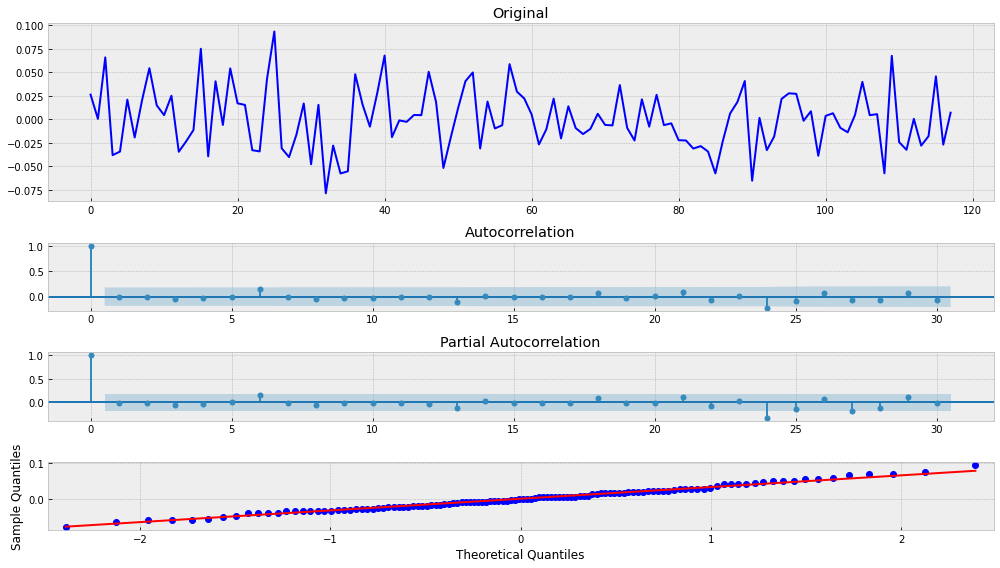

In [51]:
tsplot(mdl.resid, lags=30)

## MA(q)
В настоящий момент будем говорить про модель MA(q) - как про модель авторегресии на случайном шуме

$y_t = \sum_{j=0}^{Q} b_j \epsilon_{t-j}$

## ARMA(p,q)

Модель ARMA(p, q) представляет собой соединение двух моделей:
- AR(P) - авторегрессии на знанениях временного ряда
- MA(q) - авторегрессии на ошибках первой

AR(p) пытается предсказать "значение" временного ряда, а MA(q) пытается поймать шоковые явления, наблюдаемые в оставшемся случайном шуме.

$y_t = \sum_{i=1}^P a_i x_{t-i} + \sum_{i=1}^Q b_i \epsilon_{t-i} + \epsilon_t + c$

Сделаем симуляцию процесса ARMA и сразу его зафитим

Results of Dickey-Fuller Test:
Test Statistic                -1.789014e+01
p-value                        2.979789e-30
#Lags Used                     1.500000e+01
Number of Observations Used    4.984000e+03
Critical Value (1%)           -3.431663e+00
Critical Value (5%)           -2.862120e+00
Critical Value (10%)          -2.567079e+00
dtype: float64
                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 5000
Model:                     ARMA(2, 2)   Log Likelihood               -7105.938
Method:                           mle   S.D. of innovations              1.002
Date:                Tue, 23 Feb 2021   AIC                          14221.876
Time:                        13:47:28   BIC                          14254.462
Sample:                             0   HQIC                         14233.297
                                                                              
              

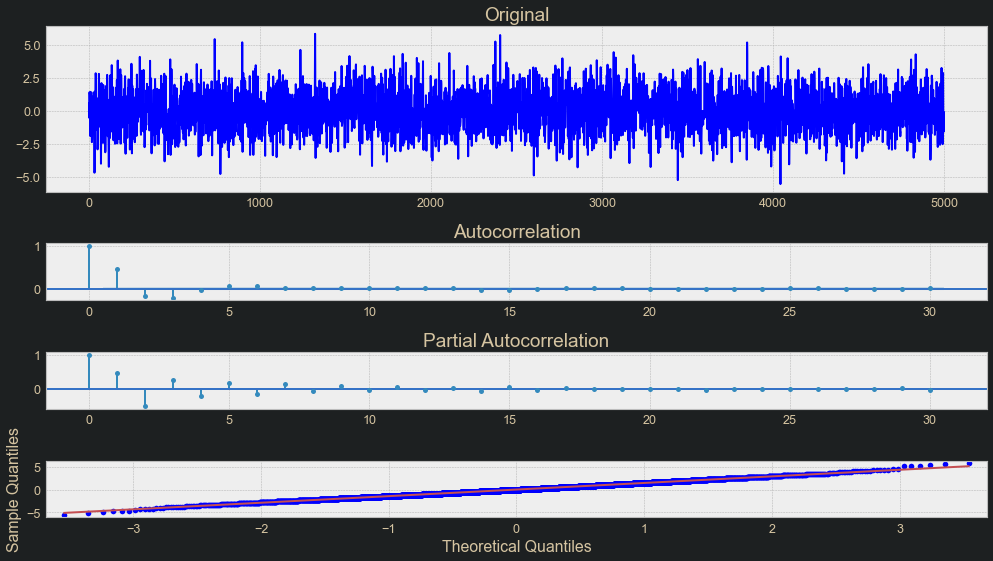

In [62]:
# Simulate an ARMA(2, 2) model with alphas=[0.5,-0.25] and betas=[0.5,-0.3]
max_lag = 30

n = int(5000) # lots of samples to help estimates
burn = int(n/10) # number of samples to discard before fit

alphas = np.array([0.5, -0.25])
betas = np.array([0.5, -0.3])
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

arma22 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n, burnin=burn)
tsplot(arma22, lags=max_lag)

mdl = smt.ARMA(arma22, order=(2, 2)).fit(maxlag=max_lag, method='mle', trend='nc', burnin=burn)
print(mdl.summary())

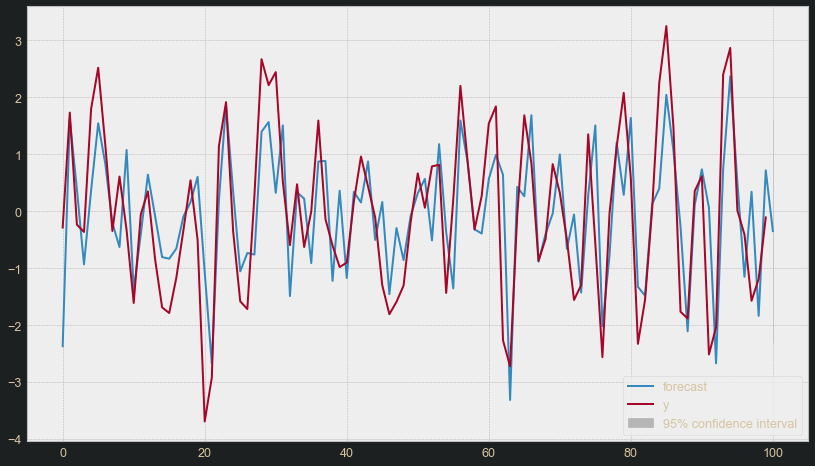

In [65]:
# plot_predict строит предсказание и по нему доверительный интервал

with plt.style.context('bmh'):
    plt.figure(figsize=(14,8))
    ax = plt.axes()
    mdl.plot_predict(start=4900, end=5000, ax=ax)

p, q - гипер параметры => их можно подбирать. Как выбрать лучшие? AIC - Информационный критерий Акаике

In [61]:
mdl.aic

-0.0345740806253133

## Практика! Реализуйте подбор гиперпараметров модели international-airline-passengers
Информационный критерий живет в вовзращаемом значении fit (у ARMA), чем меньше - тем лучше модель

Применим модель ARMA к нашей TS

In [76]:
series = pd.read_csv("C:/Users/Timvo/JupyterFolder/ITACADEMY/LESSON32(TIME_SERIES_ANALIZE)/Series/international-airline-passengers.csv")['Count']


Results of Dickey-Fuller Test:
Test Statistic                -1.303613e+01
p-value                        2.291255e-24
#Lags Used                     2.400000e+01
Number of Observations Used    4.975000e+03
Critical Value (1%)           -3.431665e+00
Critical Value (5%)           -2.862121e+00
Critical Value (10%)          -2.567079e+00
dtype: float64


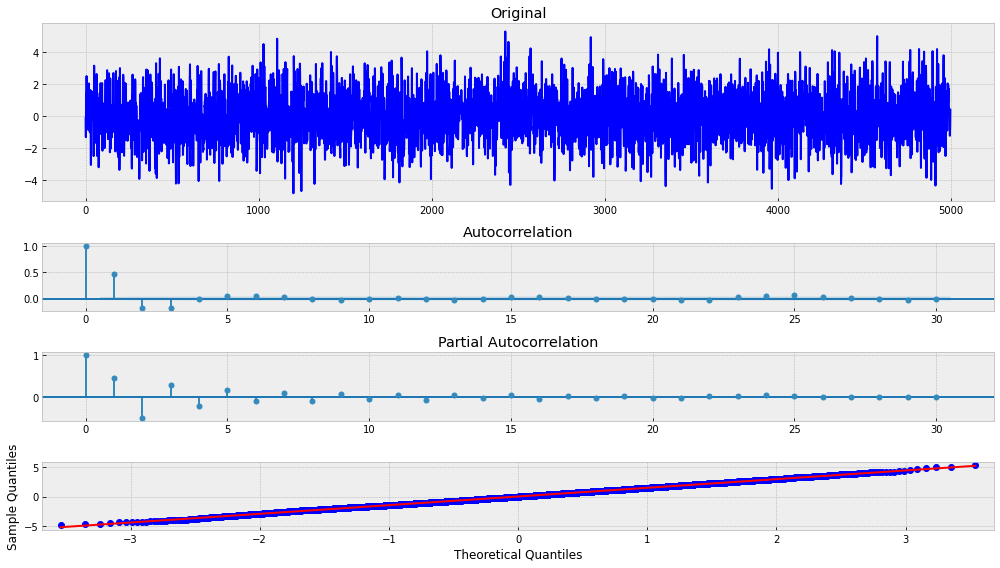

In [58]:
max_lag = 30
n = int(5000) # lots of samples to help estimates
burn = int(n/10) # number of samples to discard bef
alphas = np.array([0.5, -0.25])
betas = np.array([0.5, -0.3])
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

arma22 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n, burnin=burn)
tsplot(arma22, lags=max_lag)



In [77]:
series = boxcox(series, 0) # для приведения к стационарному
series = np.diff(series)


In [78]:
aics = [[0]*8 for _ in range(8)]
for p in range(2,8):
    for q in range(2,8):
        mdl = smt.ARMA(series, order=(p, q)).fit(maxlag=max_lag, method='mle', trend='nc', burnin=burn)
        aics[p][q] = mdl.aic

In [80]:
aics[7][7]

-380.4771146444139

ValueError: x and y must have same first dimension, but have shapes (101,) and (0,)

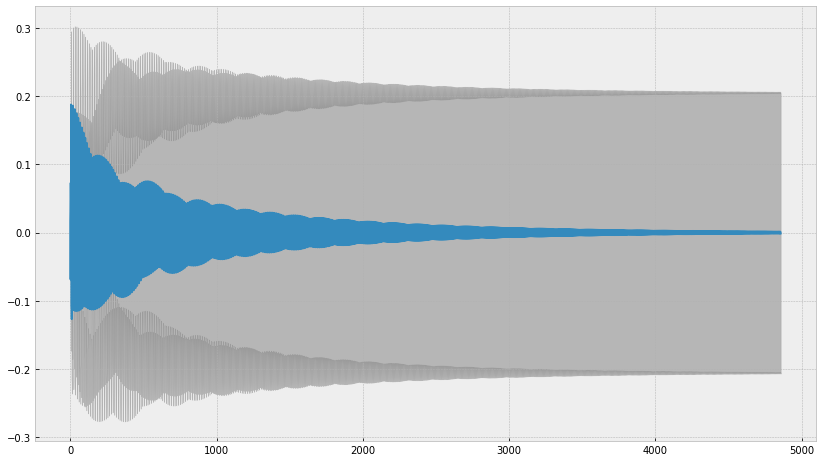

In [81]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14,8))
    ax = plt.axes()
    mdl.plot_predict(start=4900, end=5000, ax=ax)

## ARIMA (p,d,q)

ARIMA - естественное расширение модели ARMA. Как мы уже хорошо знаем - многие временные ряды не стационарны, но они могут такими стать в результате операции дифференцирования. В модели ARIMA "дифференцирование" (в количестве d-раз) вносится в саму модель


$\delta^p y_t = c + \sum_{i=1}^p a_i \delta^d y_{t-i} + \sum_{j=1}^q b_j \epsilon_{t-j} + \epsilon_t$

aic: -461.63880 | order: (4, 0, 4)
Results of Dickey-Fuller Test:
Test Statistic                  -4.343186
p-value                          0.000374
#Lags Used                      11.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


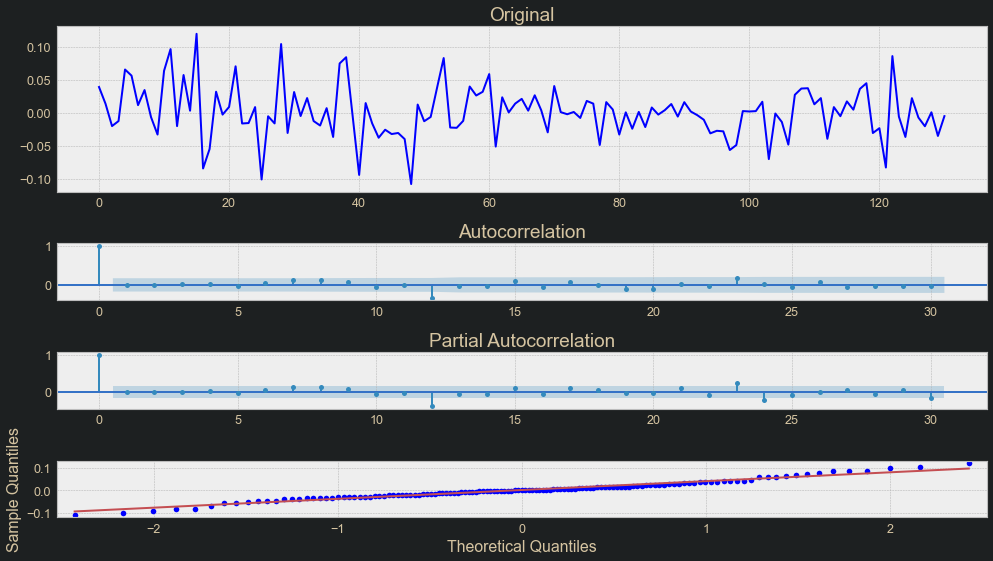

In [26]:
best_aic = np.inf 
best_order = None
best_mdl = None

for i in range(5):
    for d in range(5):
        for j in range(5):
            try:
                tmp_mdl = smt.ARIMA(series, order=(i,d,j)).fit(method='mle', trend='nc')
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, d, j)
                    best_mdl = tmp_mdl
            except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))


tsplot(best_mdl.resid, lags=30)

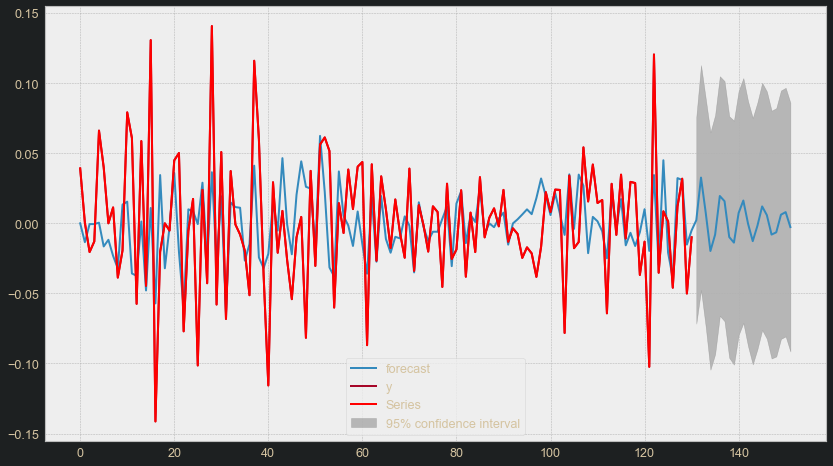

In [27]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14,8))
    ax = plt.axes()
    best_mdl.plot_predict(0, len(series)+20, ax=ax)
    plt.plot(series, color='red', label='Series')
    plt.legend()
    plt.show()

Другие вариации для класса ARMA:
- SARIMA - арима с учетом сезонности
- ARIMAX/SARIMAX

## ARCH

AutoRegressive Conditional Heteroscedasticit - пытаемся объяснить дисперсию в ряде через предыдущие значения (применяя к ним AR)

Пусть временной ряд представляется в таком виде:

$u_t = \epsilon_t * \sqrt{\alpha_0 + \sum_{i=1}^q \alpha_i u_{t-i}^2}$

Тогда условная дисперсия ряда будет равна

$\sigma_t^2 = V(u_t | u_{t-1}, ..., u_{t-q}) = \alpha_0 + \sum_{i=1}^q \alpha_i u_{t-i}^2$

Получили модель ARCH(q) условной дисперсии. Требуем, чтобы все коэффициенты были больше 0 (иначе может получится отрицательная дисперсия)

Results of Dickey-Fuller Test:
Test Statistic                 -31.621932
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    999.000000
Critical Value (1%)             -3.436913
Critical Value (5%)             -2.864437
Critical Value (10%)            -2.568313
dtype: float64


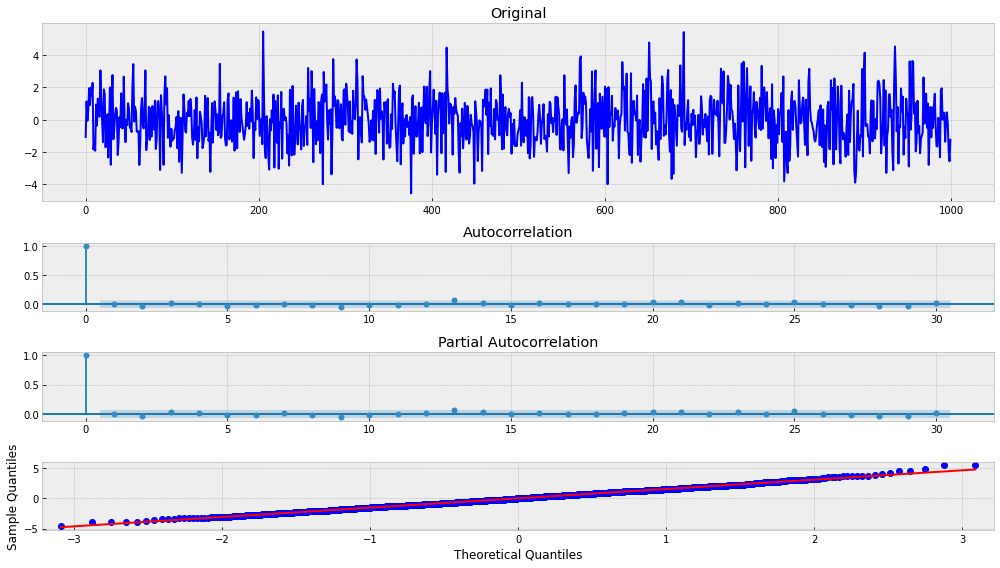

In [82]:
# Simulate ARCH(1) series

np.random.seed(13)

a0 = 2
a1 = .5

y = w = np.random.normal(size=1000)
Y = np.empty_like(y)

for t in range(len(y)):
    Y[t] = w[t] * np.sqrt((a0 + a1*y[t-1]**2))

# simulated ARCH(1) series, looks like white noise
tsplot(Y, lags=30)

## GARCH

Добавляем зависимость от прошлых значений самой условной дисперсии. Получаем модель GARCH(p, q)

$\sigma_t^2 = V(u_t | u_{t-1}, ..., u_{t-q}) = \alpha_0 + \sum_{i=1}^q \alpha_i u_{t-i}^2 + \sum_{j=1}^p \beta_j \sigma_{t-j}^2$

GARCH - по сути - модель ARMA примененная к дисперсии ряда

## Реализуем процесс GARCH, нарисуем его график, применим к нему модель ARIMA и посмотрим на график остатков

Results of Dickey-Fuller Test:
Test Statistic                  -96.275609
p-value                           0.000000
#Lags Used                        0.000000
Number of Observations Used    9999.000000
Critical Value (1%)              -3.431004
Critical Value (5%)              -2.861829
Critical Value (10%)             -2.566924
dtype: float64


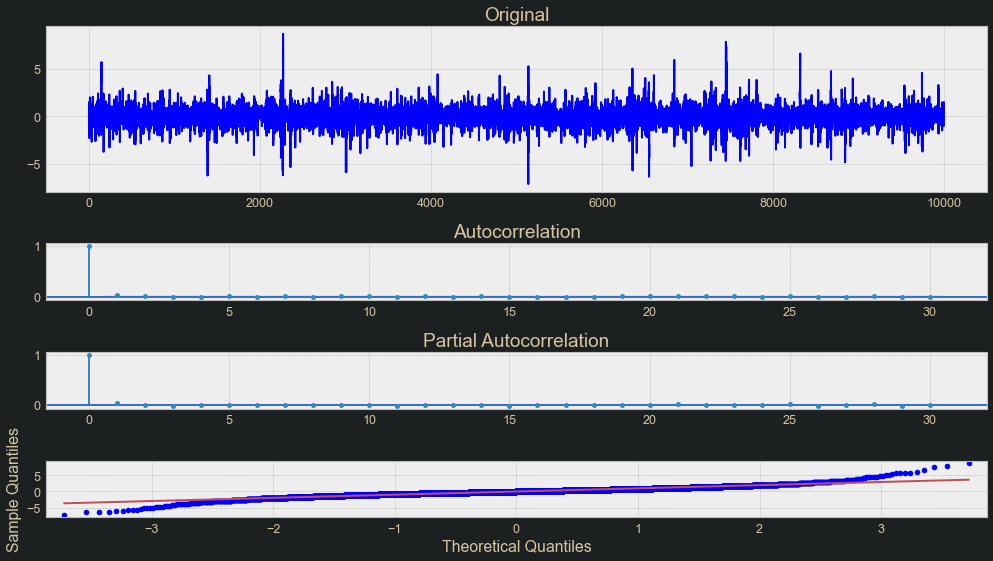

In [29]:
# симуляция GARCH(1,1) процесса
np.random.seed(2)
a0 = 0.2                     # вводим коэффициенты
a1 = 0.5
b1 = 0.3

n = 10000                    # сколько нужно измерений
w = np.random.normal(size=n)
eps = np.zeros_like(w)
siqsq = np.zeros_like(w)

for i in range(1,n):
    siqsq[i] = a0 + a1 * (eps[i-1]**2) + b1*siqsq[i-1] # вычисление по формуле
    eps[i] = w[i] * np.sqrt(siqsq[i])
    
tsplot(eps, lags=30)

In [30]:
from arch import arch_model
am = arch_model(eps)
res = am.fit(update_freq=5)
print(res.summary())

Iteration:      5,   Func. Count:     38,   Neg. LLF: 12311.793683614378
Iteration:     10,   Func. Count:     71,   Neg. LLF: 12238.592658753043
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 12237.30326731947
            Iterations: 13
            Function evaluations: 89
            Gradient evaluations: 13
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                      GARCH   Log-Likelihood:               -12237.3
Distribution:                  Normal   AIC:                           24482.6
Method:            Maximum Likelihood   BIC:                           24511.4
                                        No. Observations:                10000
Date:                Tue, Feb 23 2021   Df Residuals:                     9996
Time:       

# Продолжаем анализировать полеты

Применим ARIMA к нашему временному ряду

In [91]:
def _get_best_model(TS):
    best_aic = np.inf 
    best_order = None
    best_mdl = None

    for i in range(0,11):
        for d in range(0,11):
            for j in range(0,11):
                try:
                    tmp_mdl = smt.ARIMA(TS, order=(i,d,j)).fit(
                        method='mle', trend='nc'
                    )
                    tmp_aic = tmp_mdl.aic
                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (i, d, j)
                        best_mdl = tmp_mdl
                except: continue
    print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))                    
    return best_aic, best_order, best_mdl

#aic, order, mdl = _get_best_model(series)

Results of Dickey-Fuller Test:
Test Statistic                  -4.343186
p-value                          0.000374
#Lags Used                      11.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


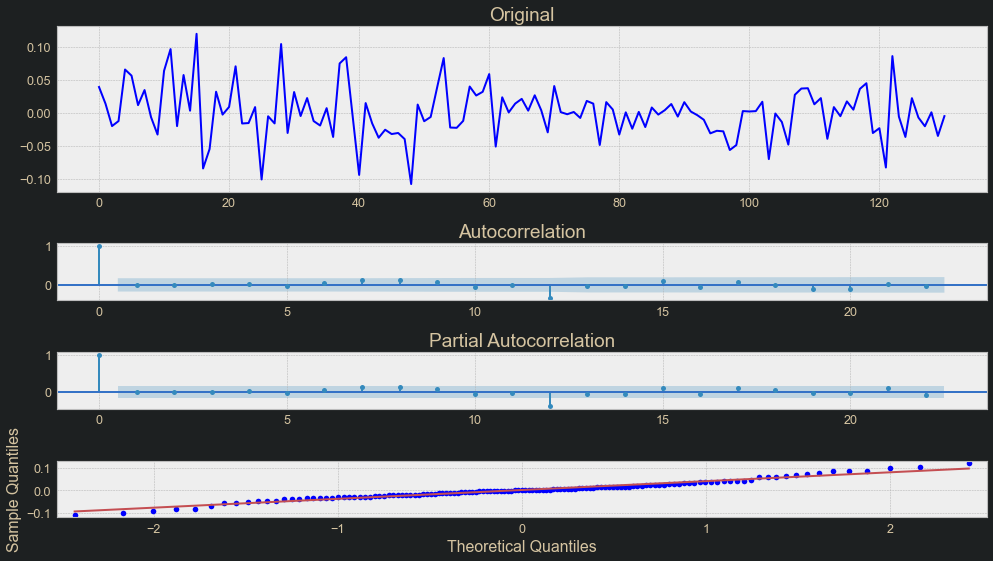

In [32]:
tsplot(mdl.resid)

### Применим GARCH

In [33]:
# Теперь мы можем подогнать модель arch, используя наилучшие параметры модели arima
p_ = order[0]
o_ = order[1]
q_ = order[2]

# Используя распределение Стьюдента t обычно обеспечивает лучший fit
am = arch_model(series, p=p_, o=o_, q=q_, dist='StudentsT')
res = am.fit(update_freq=5, disp='off')
print(res.summary())

                        Constant Mean - GARCH Model Results                         
Dep. Variable:                            y   R-squared:                      -0.000
Mean Model:                   Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                            GARCH   Log-Likelihood:                229.094
Distribution:      Standardized Student's t   AIC:                          -436.188
Method:                  Maximum Likelihood   BIC:                          -404.561
                                              No. Observations:                  131
Date:                      Tue, Feb 23 2021   Df Residuals:                      120
Time:                              11:34:33   Df Model:                           11
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------

Results of Dickey-Fuller Test:
Test Statistic                  -4.443325
p-value                          0.000249
#Lags Used                      12.000000
Number of Observations Used    118.000000
Critical Value (1%)             -3.487022
Critical Value (5%)             -2.886363
Critical Value (10%)            -2.580009
dtype: float64


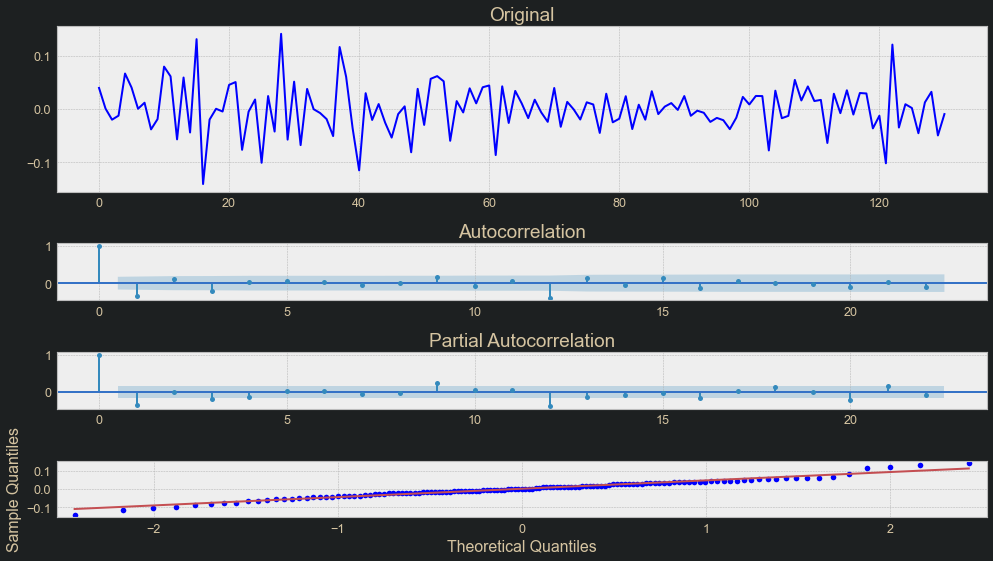

In [34]:
tsplot(res.resid)

## Практика! Проведите анализ для monthly-boston-armed-robberies-j

In [89]:
new_series = pd.read_csv("C:/Users/Timvo/JupyterFolder/ITACADEMY/LESSON32(TIME_SERIES_ANALIZE)/Series/monthly-boston-armed-robberies-j.csv")["Count"].values.astype('float64')
new_series = boxcox(new_series, 0)
new_series = np.diff(new_series)

In [90]:
new_series

array([-0.05001042,  0.24846136, -0.22314355,  0.07232066, -0.12361396,
        0.14660347, -0.22884157,  0.10821358, -0.10821358, -0.18805223,
        0.52452447,  0.02020271,  0.16551444,  0.06559728, -0.67739882,
        0.19782574,  0.18658596,  0.12014431,  0.12405265, -0.05129329,
       -0.09180755,  0.29725152,  0.25131443, -0.19574458, -0.17693071,
       -0.1198012 ,  0.42348361,  0.11247798, -0.29479954,  0.43363599,
        0.25234271, -0.14698219, -0.21278076,  0.26157093,  0.1676644 ,
        0.05864873, -0.24231347,  0.12136086, -0.25029454,  0.04485057,
       -0.39239303,  0.44368632,  0.10285739, -0.18986876, -0.17869179,
        0.0529224 , -0.21800215,  0.23841102,  0.07770898,  0.04567004,
       -0.2186892 ,  0.08515781,  0.24334626,  0.21511138,  0.20359896,
        0.21680773, -0.22208479, -0.08269172,  0.02272825, -0.26912866,
        0.16874948,  0.06025919, -0.13771725,  0.21098945, -0.17151064,
        0.57697575, -0.20875481, -0.05035389,  0.26991962, -0.04

In [92]:
aic, order, mdl = _get_best_model(new_series)

aic: -44.47600 | order: (2, 0, 4)


## По простому

Такой подход является не совсем корректным (для прогнозирования свойств ВР), но он часто позволяет получать неплохие результаты в сжатые сроки

### Генерируем большое количество фичей для нашего временного ряда

In [96]:
series = pd.read_csv("C:/Users/Timvo/JupyterFolder/ITACADEMY/LESSON32(TIME_SERIES_ANALIZE)/Series/international-airline-passengers.csv")


In [97]:
def prepareData(data, lag_start=5, lag_end=20, test_size=0.15):
    
    data = pd.DataFrame(data.copy())
    
    # считаем индекс в датафрейме, после которого начинается тестовый отрезок
    test_index = int(len(data)*(1-test_size))
    
    # добавляем лаги исходного ряда в качестве признаков
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.Count.shift(i)
        
    data = data.dropna()
    data = data.reset_index(drop=True)
    data = data.drop(["Month"], axis=1)
     
    # разбиваем весь датасет на тренировочную и тестовую выборку
    X_train = data.loc[:test_index].drop(["Count"], axis=1)
    y_train = data.loc[:test_index]["Count"]
    X_test = data.loc[test_index:].drop(["Count"], axis=1)
    y_test = data.loc[test_index:]["Count"]
    
    return X_train, X_test, y_train, y_test

In [98]:
X_train, X_test, y_train, y_test = prepareData(series, lag_start=1, lag_end=20, test_size=0.3)

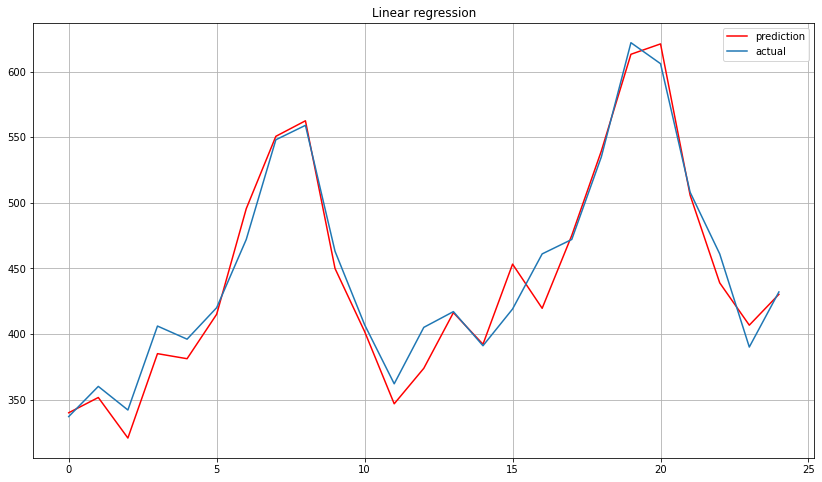

In [99]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)
prediction = lr.predict(X_test)

plt.figure(figsize=(14, 8))
plt.plot(prediction, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.legend(loc="best")
plt.title("Linear regression")
plt.grid(True);

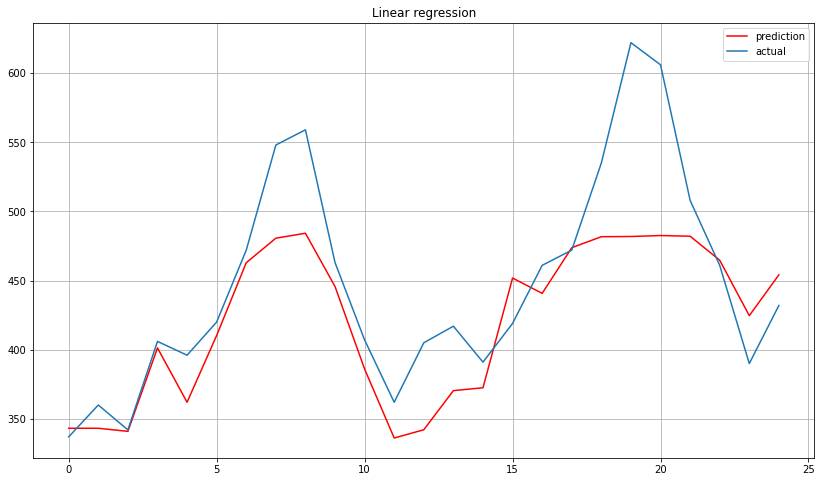

In [107]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor(max_depth=10,n_estimators=500,n_jobs=-1,random_state=42,max_leaf_nodes=23)
rfr.fit(X_train,y_train)
rfr_preds = rfr.predict(X_test)

plt.figure(figsize=(14, 8))
plt.plot(rfr_preds, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.legend(loc="best")
plt.title("Linear regression")
plt.grid(True);

## Полезная информация
- https://people.duke.edu/~rnau/411home.htm
- https://bmcbioinformatics.biomedcentral.com/articles/10.1186/1471-2105-15-276
- http://www.blackarbs.com/blog/time-series-analysis-in-python-linear-models-to-garch/11/1/2016